<a href="https://colab.research.google.com/github/ucaokylong/U_net_for_segmentation_and_translation/blob/main/Unet_SuperResolution_and_InpaintingImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Xây dựng mô hình kiến trúc U-Net

In [22]:
import tensorflow as tf

#import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
#from tensorflow.keras.layers.convolutional import Conv2DTranspose

class BuildUnet():
    def __init__(self):
        pass

    def extract_first_features(self, filters, size):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                                          kernel_initializer=initializer, use_bias=False))
        result.add(tf.keras.layers.LeakyReLU())

        return result

    def downsample(self, filters, size):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                          kernel_initializer=initializer, use_bias=False))
        result.add(tf.keras.layers.LeakyReLU())

        return result

    def upsample(self, filters):
        initializer = tf.random_normal_initializer(0., 0.02, seed=42)

        result = tf.keras.Sequential()
        result.add(tf.keras.layers.UpSampling2D(interpolation='bilinear'))
        #result.add(Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same'))
        result.add(tf.keras.layers.Conv2D(filters, 3, padding='same',
                                          kernel_initializer=initializer, use_bias=False))
        result.add(tf.keras.layers.ReLU())

        return result

    def UNet_process(self, x, is_skip_connection=True):
        down_stack = [
            self.downsample(64, 4),  # (bs, 128, 128, 64)
            self.downsample(256, 4), # (bs, 64, 64, 256)
            self.downsample(512, 4), # (bs, 32, 32, 512)
            self.downsample(512, 4), # (bs, 16, 16, 512)
            self.downsample(512, 4), # (bs, 8, 8, 512)
        ]

        up_stack = [
            self.upsample(512), # (bs, 16, 16, 512)
            self.upsample(512), # (bs, 32, 32, 512)
            self.upsample(256), # (bs, 64, 64, 256)
            self.upsample(64),  # (bs, 128, 128, 64)
        ]

        initializer = tf.random_normal_initializer(0., 0.02)
        OUTPUT_CHANNELS = 3

        sample_l = tf.keras.layers.UpSampling2D(interpolation='bilinear')
        #sample_l = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')
        last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 3, padding='same', activation='tanh',
                                      kernel_initializer=initializer, use_bias=False)

        concat = tf.keras.layers.Concatenate()

        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            if is_skip_connection:
                x = concat([x, skip])

        x = sample_l(x)
        x = last(x)

        return x

    def build_model(self, is_skip_connection=True, input_shape=(256, 256, 3)):
        # multiple inputs
        inputs = tf.keras.layers.Input(shape=input_shape)

        x = inputs

        # ablation study 1
        fextract1 = self.extract_first_features(64, 3)
        x = fextract1(x) # (1,256,256,64)

        outputs = self.UNet_process(x, is_skip_connection=is_skip_connection)

        return tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [24]:
build_unet = BuildUnet()
unet_model = build_unet.build_model(is_skip_connection=True)

unet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_40 (Sequential)  (None, 256, 256, 64)         1728      ['input_5[0][0]']             
                                                                                                  
 sequential_41 (Sequential)  (None, 128, 128, 64)         65536     ['sequential_40[0][0]']       
                                                                                                  
 sequential_42 (Sequential)  (None, 64, 64, 256)          262144    ['sequential_41[0][0]']       
                                                                                            

# Problem 2:

## Prepare Super Resolution Dataset

In [25]:
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Model

In [26]:
!unzip K_LHR_image.zip

unzip:  cannot find or open K_LHR_image.zip, K_LHR_image.zip.zip or K_LHR_image.zip.ZIP.


In [ ]:
!pwd

/content


In [ ]:
LHR_TRAIN_DATA_PATH = '/content/K_LHR_image/train'
LHR_VAL_DATA_PATH = '/content/K_LHR_image/val'


BATCH_SIZE  = 32
BUFFER_SIZE = BATCH_SIZE*10
IMG_WIDTH   = 64
IMG_HEIGHT  = 64

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)

    input_image  = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    target_image = image

    input_image  = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)

    # clip
    # input_image = tf.clip_by_value(input_image, 0.0, 255.0)


    return input_image, target_image

(64, 64, 3)
(256, 256, 3)


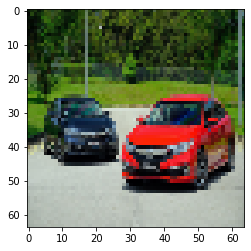

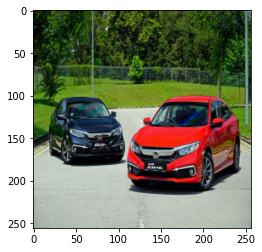

In [ ]:
input_image, target_image = load(LHR_TRAIN_DATA_PATH+'/0.png')
print(input_image.shape)
print(target_image.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(input_image/255.0)
plt.figure()
plt.imshow(target_image/255.0)

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_image, target_image):
    input_image  = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1

    return input_image, target_image

#@tf.function()
def random_jitter(input_image, target_image):
    if tf.random.uniform(()) > 0.5:
        input_image  = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)

    return input_image, target_image

def load_image_train(image_file):
    input_image, target_image = load(image_file)
    # input_image, target_image = random_jitter(input_image, target_image)
    input_image, target_image = normalize(input_image, target_image)

    return input_image, target_image

def load_image_test(image_file):
    input_image, target_image = load(image_file)
    input_image, target_image = normalize(input_image, target_image)

    return input_image, target_image

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(LHR_TRAIN_DATA_PATH + '/*.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

# test_dataset
test_dataset = tf.data.Dataset.list_files(LHR_VAL_DATA_PATH + '/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:
def generator_loss(fake, target):
    l1_loss = tf.reduce_mean(tf.abs(fake-target))

    return l1_loss

In [ ]:
def evaluate(model, epoch):
    psnr_mean = 0.0
    count = 0
    for inputs, targets in test_dataset:
        fake = model([inputs], training=True)

        psnr = tf.image.psnr(fake*0.5 + 0.5, targets*0.5 + 0.5, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        # psnr_mean = psnr_mean_l

        psnr_mean += __psnr_mean
        count =count + 1

    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)

    return psnr_mean

def generate_images(model, inputs, targets):
    fake = model([inputs], training=True)
    plt.figure(figsize=(15,20))

    display_list = [inputs[0], targets[0], fake[0]]
    title = ['Input', 'Real', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## Train

In [ ]:
build_unet = BuildUnet()
unet_model = build_unet.build_model(is_skip_connection=True)

image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
x = tf.keras.layers.Resizing(height=256, width=256)(image_input)
x = unet_model(x)
SR_unet_model = Model(inputs=image_input, outputs=x)

SR_unet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 model_2 (Functional)        (None, 256, 256, 3)       20550720  
                                                                 
Total params: 20,550,720
Trainable params: 20,550,720
Non-trainable params: 0
_________________________________________________________________


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        # output
        fake = SR_unet_model([inputs], training=True)
        loss = generator_loss(fake, targets)


    generator_gradients = tape.gradient(loss, SR_unet_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, SR_unet_model.trainable_variables))

    return loss



def fit(train_ds, epochs, test_ds):
    best_pnsr = 0.0
    for epoch in range(epochs):
        # Train
        total_loss = 0.0
        for inputs, targets in train_ds:
            loss = train_step(inputs, targets)
            total_loss = total_loss + loss
        total_loss = total_loss/400
        print('epoch: {}   loss: {}'.format(epoch, total_loss))

        pnsr = evaluate(SR_unet_model, epoch)
        if best_pnsr < pnsr:
            best_pnsr = pnsr

            for inputs, targets in test_ds.take(1):
                generate_images(SR_unet_model, inputs, targets)


In [ ]:
EPOCHS = 40
fit(train_dataset, EPOCHS, test_dataset)

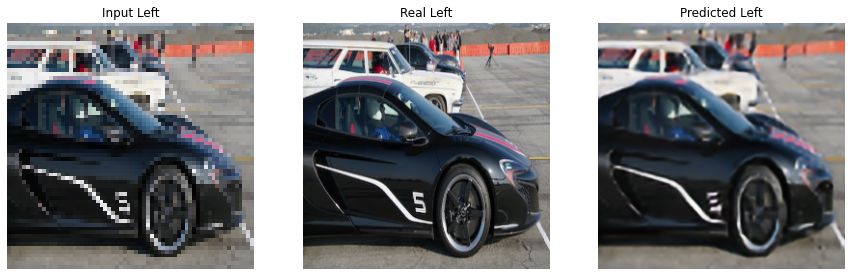

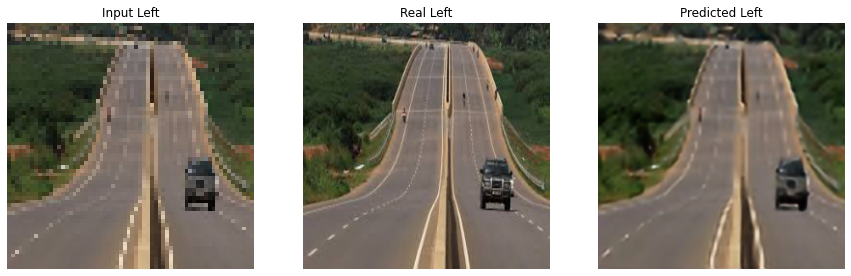

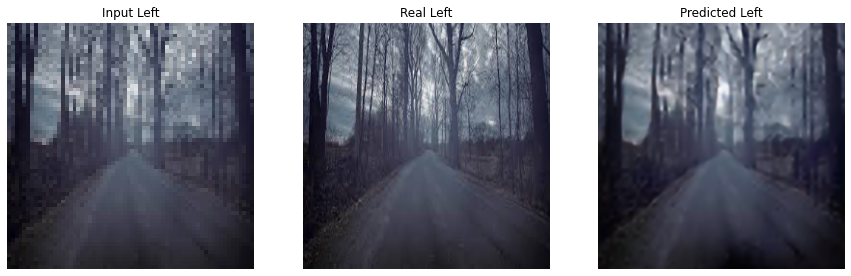

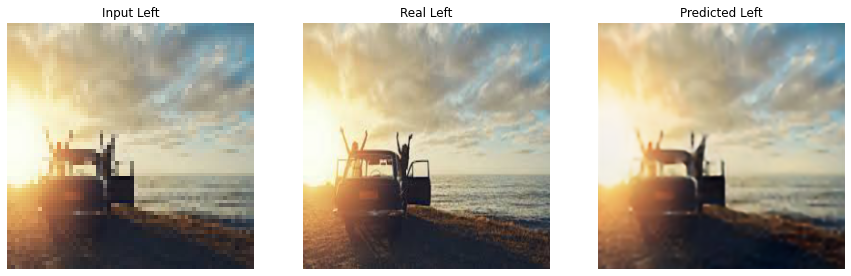

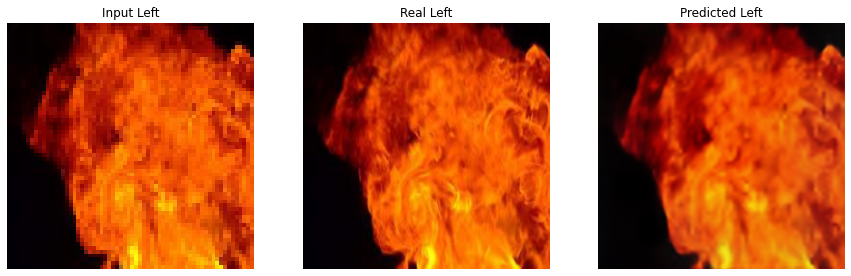

In [ ]:
for _ in range(5):
    for inputs, targets in test_dataset.take(1):
        fake = SR_unet_model([inputs], training=True)
        plt.figure(figsize=(15,20))

        display_list = [inputs[0], targets[0], fake[0]]
        title = ['Input Left', 'Real Left', 'Predicted Left']

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

# Problem 3:

## U-Net model

In [ ]:
class BuildUnet():
    def __init__(self):
        self.down_filters = [64, 128, 256, 512]
        self.up_filters = [512, 256, 128, 64]

    def extract_first_features(self, inputs, filters):
        x = layers.Conv2D(filters=filters, kernel_size=(1,1), padding='same',
                          kernel_initializer='he_normal', use_bias=False)(inputs)
        x = layers.LeakyReLU()(x)

        return x


    def DoubleConv2D(self, inputs, filters):
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same',
                          kernel_initializer='he_normal', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same',
                          kernel_initializer='he_normal', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        return x


    def downsample(self, inputs, filters):
        bdown = self.DoubleConv2D(inputs, filters)
        x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(bdown)

        return x, bdown


    def upsample(self, inputs1, inputs2, filters):
        inputs1 = layers.UpSampling2D(interpolation='bilinear')(inputs1)
        inputs1 = layers.Conv2D(filters=filters, kernel_size=(1,1),
                                kernel_initializer='he_normal', use_bias=False)(inputs1)
        inputs1 = layers.BatchNormalization()(inputs1)
        inputs1 = layers.LeakyReLU()(inputs1)
        x = layers.Concatenate()([inputs1, inputs2])
        x = self.DoubleConv2D(x, filters)

        return x


    def build_model(self, input_shape=(256,256,3)):
        inputs = layers.Input(shape=input_shape)
        x = self.extract_first_features(inputs, filters=64)

        # Downsampling through the model
        skips = []
        for df in self.down_filters:
            x, bdown = self.downsample(x, filters=df)
            skips.append(bdown)

        # Mid
        x = self.DoubleConv2D(x, filters=1024)

        # Upsampling and establishing the skip connections
        skips = reversed(skips)
        for uf, skip in zip(self.up_filters, skips):
            x = self.upsample(x, skip, filters=uf)

        # Final
        outputs = layers.Conv2D(filters=input_shape[-1], kernel_size=(1,1), activation='tanh',
                                      kernel_initializer='he_normal', use_bias=False)(x)

        model = Model(inputs=[inputs], outputs=[outputs])

        return model

In [ ]:
build_unet = BuildUnet()
unet_model = build_unet.build_model()

unet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 256, 256, 64  192         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 256, 256, 64  0           ['conv2d_33[0][0]']              
                                )                                                           

## Prepare Inpainting dataset

In [ ]:
import numpy as np
import cv2

In [ ]:
LHR_TRAIN_DATA_PATH = '/content/K_LHR_image/train'
LHR_VAL_DATA_PATH = '/content/K_LHR_image/val'

BATCH_SIZE  = 8
BUFFER_SIZE = BATCH_SIZE*10
IMG_WIDTH   = 256
IMG_HEIGHT  = 256

def create_mask(image):
    masked_image = tf.identity(image)
    ## Prepare masking matrix
    mask = np.full((IMG_WIDTH,IMG_HEIGHT,3), 0, np.uint8)
    for _ in range(np.random.randint(1, 15)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, IMG_WIDTH), np.random.randint(1, IMG_WIDTH)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, IMG_HEIGHT), np.random.randint(1, IMG_HEIGHT)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 15)
      # Draw black line on the black mask
      cv2.line(mask,(x1,y1),(x2,y2),(255,255,255),thickness)

    # Perforn bitwise and operation to mak the image
#     masked_image = cv2.bitwise_and(img, mask)
    masked_image = tf.bitwise.bitwise_or(masked_image, mask)
    masked_image = tf.convert_to_tensor(masked_image)
    masked_image = tf.cast(masked_image, tf.float32)
    return masked_image

def tf_function(image):
    masked_image = tf.numpy_function(create_mask, [image], tf.float32)
    return masked_image


def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)

    input_image  = tf_function(image)
    target_image = image

    input_image  = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)

    return input_image, target_image

(256, 256, 3)
(256, 256, 3)


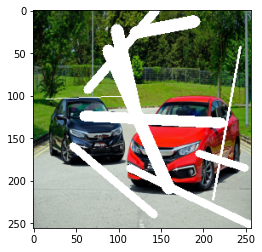

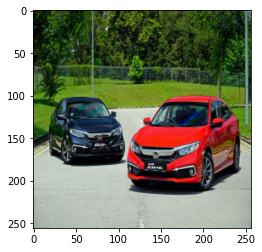

In [ ]:
input_image, target_image = load(LHR_TRAIN_DATA_PATH+'/0.png')
print(input_image.shape)
print(target_image.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(input_image/255.0)
plt.figure()
plt.imshow(target_image/255.0)

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_image, target_image):
    input_image  = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1

    return input_image, target_image


def load_image_train(image_file):
    input_image, target_image = load(image_file)
    input_image, target_image = normalize(input_image, target_image)

    return input_image, target_image

def load_image_test(image_file):
    input_image, target_image = load(image_file)
    input_image, target_image = normalize(input_image, target_image)

    return input_image, target_image

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(LHR_TRAIN_DATA_PATH + '/*.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

# test_dataset
test_dataset = tf.data.Dataset.list_files(LHR_VAL_DATA_PATH + '/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:
def generator_loss(fake, target):
    l1_loss = tf.reduce_mean(tf.abs(fake-target))

    return l1_loss

def evaluate(model, epoch):
    psnr_mean = 0.0
    count = 0
    for inputs, targets in test_dataset:
        fake = model([inputs], training=True)

        psnr = tf.image.psnr(fake*0.5 + 0.5, targets*0.5 + 0.5, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        # psnr_mean = psnr_mean_l

        psnr_mean += __psnr_mean
        count =count + 1

    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)

    return psnr_mean

def generate_images(model, inputs, targets):
    fake = model([inputs], training=True)
    plt.figure(figsize=(15,20))

    display_list = [inputs[0], targets[0], fake[0]]
    title = ['Input', 'Real', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## Train

In [ ]:
build_unet = BuildUnet()
unet_model = build_unet.build_model()

# image_input = layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
# x = tf.keras.layers.Resizing(height=IMG_HEIGHT, width=IMG_WIDTH)(image_input)
# x = unet_model(x)
# Inp_unet_model= Model(inputs=image_input, outputs=x)
Inp_unet_model = unet_model
Inp_unet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 64  192         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_41 (LeakyReLU)     (None, 256, 256, 64  0           ['conv2d_57[0][0]']              
                                )                                                           

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        # output
        fake = Inp_unet_model([inputs], training=True)
        loss = generator_loss(fake, targets)


    generator_gradients = tape.gradient(loss, Inp_unet_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, Inp_unet_model.trainable_variables))

    return loss



def fit(train_ds, epochs, test_ds):
    best_pnsr = 0.0
    for epoch in range(epochs):
        # Train
        total_loss = 0.0
        for inputs, targets in train_ds:
            loss = train_step(inputs, targets)
            total_loss = total_loss + loss
        total_loss = total_loss/400
        print('epoch: {}   loss: {}'.format(epoch, total_loss))

        pnsr = evaluate(Inp_unet_model, epoch)
        if best_pnsr < pnsr:
            best_pnsr = pnsr

            for inputs, targets in test_ds.take(1):
                generate_images(Inp_unet_model, inputs, targets)


In [ ]:
EPOCHS = 100
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
for _ in range(5):
    for inputs, targets in test_dataset.take(1):
        fake = Inp_unet_model([inputs], training=True)
        plt.figure(figsize=(15,20))

        display_list = [inputs[0], targets[0], fake[0]]
        title = ['Input Left', 'Real Left', 'Predicted Left']


        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

# Quiz

## Ex 1

In [ ]:
import tensorflow as tf

class BuildUnet():
    def __init__(self):
        pass

    def extract_first_features(self, filters, size):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                                          kernel_initializer=initializer, use_bias=False))
        result.add(tf.keras.layers.LeakyReLU())

        return result

    def downsample(self, filters, size):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                          kernel_initializer=initializer, use_bias=False))
        result.add(tf.keras.layers.LeakyReLU())

        return result

    def upsample(self, filters):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(tf.keras.layers.UpSampling2D(interpolation='bilinear'))
        result.add(tf.keras.layers.Conv2D(filters, 3, padding='same',
                                          kernel_initializer=initializer, use_bias=False))
        result.add(tf.keras.layers.ReLU())

        return result

    def UNet_process(self, x, is_skip_connection=True):
        down_stack = [
            self.downsample(128, 4,),  # (bs, 128, 128, 64)
            self.downsample(256, 4), # (bs, 64, 64, 256)
            self.downsample(512, 4), # (bs, 32, 32, 512)
            self.downsample(512, 4), # (bs, 16, 16, 512)
            self.downsample(512, 4), # (bs, 8, 8, 512)
        ]

        up_stack = [
            self.upsample(512), # (bs, 16, 16, 512)
            self.upsample(512), # (bs, 32, 32, 512)
            self.upsample(256), # (bs, 64, 64, 256)
            self.upsample(64),  # (bs, 128, 128, 64)
        ]

        initializer = tf.random_normal_initializer(0., 0.02)
        OUTPUT_CHANNELS = 3

        sample_l = tf.keras.layers.UpSampling2D(interpolation='bilinear')
        last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 3, padding='same', activation='tanh',
                                      kernel_initializer=initializer, use_bias=False)

        concat = tf.keras.layers.Concatenate()

        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            if is_skip_connection:
                x = concat([x, skip])

        x = sample_l(x)
        x = last(x)

        return x

    def build_model(self, is_skip_connection=True, input_shape=(256, 256, 3)):
        # multiple inputs
        inputs = tf.keras.layers.Input(shape=input_shape)

        x = inputs

        # ablation study 1
        fextract1 = self.extract_first_features(64, 3)
        x = fextract1(x) # (1,256,256,64)

        outputs = self.UNet_process(x, is_skip_connection=is_skip_connection)

        return tf.keras.Model(inputs=[inputs], outputs=[outputs])

build_unet = BuildUnet()
unet_model = build_unet.build_model(is_skip_connection=True)

unet_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_70 (Sequential)     (None, 256, 256, 64  1728        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_71 (Sequential)     (None, 128, 128, 12  131072      ['sequential_70[0][0]']          
                                8)                                                          

## Ex 2

In [ ]:
import tensorflow as tf

class BuildUnet():
    def __init__(self):
        pass

    def extract_first_features(self, filters, size):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                                          kernel_initializer=initializer, use_bias=False))
        result.add(tf.keras.layers.LeakyReLU())

        return result

    def downsample(self, filters, size):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                          kernel_initializer=initializer, use_bias=False))
        result.add(tf.keras.layers.LeakyReLU())

        return result

    def upsample(self, filters):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(tf.keras.layers.UpSampling2D(interpolation='bilinear'))
        result.add(tf.keras.layers.Conv2D(filters, 3, padding='same',
                                          kernel_initializer=initializer, use_bias=False))
        result.add(tf.keras.layers.ReLU())

        return result

    def UNet_process(self, x, is_skip_connection=True):
        down_stack = [
            self.downsample(64, 4,),  # (bs, 128, 128, 64)
            self.downsample(256, 4), # (bs, 64, 64, 256)
            self.downsample(512, 4), # (bs, 32, 32, 512)
            self.downsample(512, 4), # (bs, 16, 16, 512)
            self.downsample(512, 4), # (bs, 8, 8, 512)
        ]

        up_stack = [
            self.upsample(512), # (bs, 16, 16, 512)
            self.upsample(256), # (bs, 32, 32, 512)
            self.upsample(256), # (bs, 64, 64, 256)
            self.upsample(64),  # (bs, 128, 128, 64)
        ]

        initializer = tf.random_normal_initializer(0., 0.02)
        OUTPUT_CHANNELS = 3

        sample_l = tf.keras.layers.UpSampling2D(interpolation='bilinear')
        last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 3, padding='same', activation='tanh',
                                      kernel_initializer=initializer, use_bias=False)

        concat = tf.keras.layers.Concatenate()

        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            if is_skip_connection:
                x = concat([x, skip])

        x = sample_l(x)
        x = last(x)

        return x

    def build_model(self, is_skip_connection=True, input_shape=(256, 256, 3)):
        # multiple inputs
        inputs = tf.keras.layers.Input(shape=input_shape)

        x = inputs

        # ablation study 1
        fextract1 = self.extract_first_features(64, 3)
        x = fextract1(x) # (1,256,256,64)

        outputs = self.UNet_process(x, is_skip_connection=is_skip_connection)

        return tf.keras.Model(inputs=[inputs], outputs=[outputs])

build_unet = BuildUnet()
unet_model = build_unet.build_model(is_skip_connection=True)

unet_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_90 (Sequential)     (None, 256, 256, 64  1728        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 sequential_91 (Sequential)     (None, 128, 128, 64  65536       ['sequential_90[0][0]']          
                                )                                                           